In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import binary_erosion, binary_opening
import pandas as pd
import sys
import skimage
sys.path.append("../../")
from VoltageIntensityClass import VoltageIntensity
%matplotlib inline
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func, get_polyfit_func
from alienlab.plot import PlotFigure
extension = ".png"
p = PlotFigure()
p.fonttick = 15
p.fontsize=17

In [130]:
folder_RED = glob.glob("./*autofocus_RED_MPPC")[0]
print(folder_RED)

folder_BLUE = glob.glob("./*autofocus_BLUE_MPPC")[0]
print(folder_BLUE)

folder_GREEN = glob.glob("./*autofocus_GREEN_MPPC")[0]
print(folder_GREEN)


folder_DRONPA = glob.glob("./*_calib_video_BP_july2*")[0]
print(folder_DRONPA)

.\2022-07-05_21_21_autofocus_RED_MPPC
.\2022-07-05_21_16_autofocus_BLUE_MPPC
.\2022-07-05_21_25_autofocus_GREEN_MPPC
.\2022-07-06_11_32_D2_calib_video_BP_july2


## experimental details

Dissolve in minimal quantity of DMSO (Two-photon Uncaging Acridinone Live-cell (SI)) then in Phosphate Buffer 
(100mM NaCl, 5mM NaOH, 10mM HEPES)
Absorbance max for 15µM: 0.15  
Emission spectrum collected for 15µM solution emission: 690 nm, 8nm width
DDAO and Dronpa sample for video: double glass slide with double-sided tape


Video:  
- Dronpa excited at 480nm to recover the *dispersion of intensity of blue LED spot*   
- DDAO excited at 480nm to recover the *transfert function* of the instrument and to recover the *mean fluorescence intensity from blue excitation* 10 levels of intensity.   
- DDAO excited at 650nm filter 640/20nm dichroic 665nm. From mean fluo level of blue and red excitation, and excitation spectrum: we recover the level of the blue LED. From image: we recover the dispersion of intensity.

##  MPPC calibraiton of LEDs

In [131]:
#550
dict_green = {
    0: 0,
    55:7.8,
    111:14.2,
    166:20.0,
    222:25.9,
    277:31.4,
    333:36.7,
    388:41.8,
    444:46.6,}


#640
dict_red = {
    0: 0,
    55:4.7,
    111:8.8,
    166:12.8,
    222:17,
    277:21,
    333:25,
    388:28.8,
    444:32.6,}

#480
dict_blue = {
    0: 0,
    55:87.2,
    111:158,
    166:223,
    222:288,
    277:348,
    333:405,
    388:457,
    444:506,}


# DDAO 15µM

[164891.969] [1288238.5]


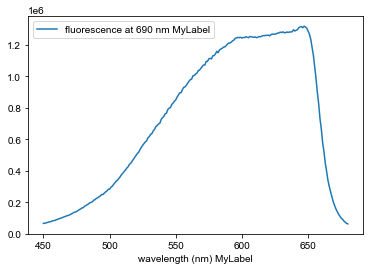

In [132]:
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
spectrum.plot(x = headers[1], y = headers[2])
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
#plt.figure()µ
#plt.plot(wavelength, fluo)
phi_480 = fluo[wavelength == 480]
phi_640 = fluo[wavelength == 640]
print(phi_480, phi_640)

# Abs Exc

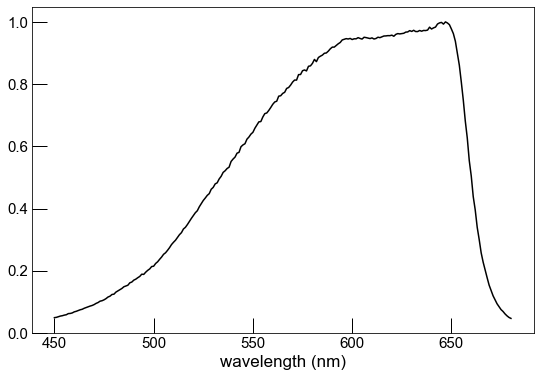

In [133]:
p.xlabel = 'wavelength (nm)'
p.ylabel = ''
fig = p.set_figure(formatx = "%d", formaty = "%0.1f")
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
plt.plot(wavelength, fluo/fluo.max(), "k", label = 'normalized excitation spectrum')
plt.savefig("images/excitation_DDAO_read_690" + extension)

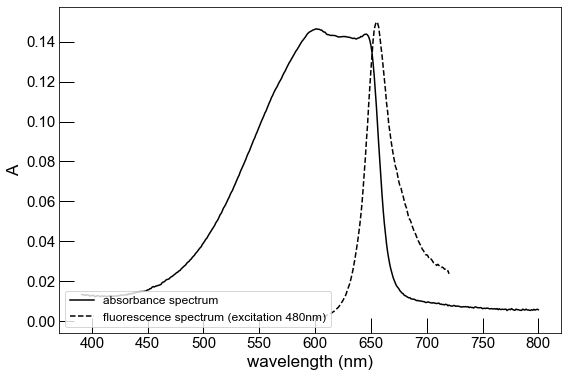

In [134]:
p.xlabel = 'wavelength (nm)'
p.ylabel = 'A'
fig = p.set_figure(formatx = "%d", formaty = "%0.2f")


file= pd.read_csv("DDAO/abs/DDAO_UV.csv", skiprows = [1], skipfooter = 320, sep = ",")
absorbance = np.array(file['Unnamed: 5']) - np.array(file['Unnamed: 3'])
wavelength = np.array(file['DDAO_15uM'])

plt.plot(wavelength, absorbance, "k", label = 'absorbance spectrum')

spectrum = pd.read_csv("2022-06-24_14_26_fluorescence_spectrum_800_DDAO.csv")
headers = spectrum.keys()
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
plt.plot(wavelength, fluo/fluo.max()*0.15, "k", linestyle="--", label = 'fluorescence spectrum (excitation 480nm)')

plt.legend(prop = {'size':12},  loc = "lower left")
plt.savefig("images/absorbance_fluorescence_DDAO_015uM" + extension)

# Dronpa2 calibration

8410.107584302486


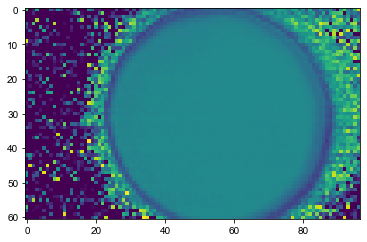

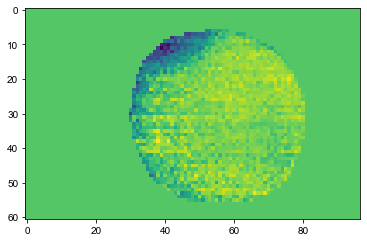

In [135]:
I_480 = np.load(glob.glob(folder_DRONPA + "/*I_480.npy")[0])
plt.imshow(I_480)
plt.figure()
np.median(I_480)
reader = imageio.get_reader(glob.glob(folder_DRONPA + "/video.tiff")[0])
im_read =  reader.get_data(10)
mask_full =im_read>4
mask = downscale_local_mean(mask_full, (10, 10))
mask = mask>0.5
mask = binary_erosion(mask, iterations= 5)
v = I_480*mask
v[v==0]=np.quantile(v, 0.75)
plt.imshow(v)
 
dronpa_480 = np.mean(I_480[mask]) 
print(dronpa_480)

## BLUE

In [136]:
images = glob.glob(folder_BLUE + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)

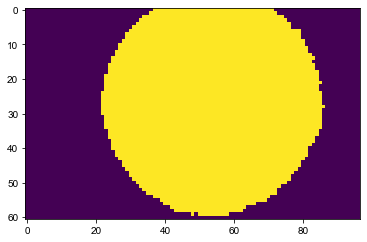

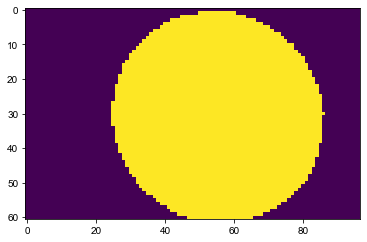

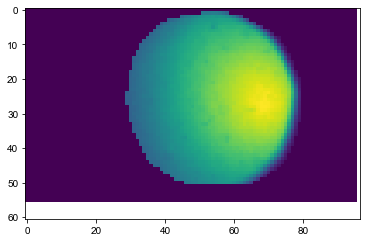

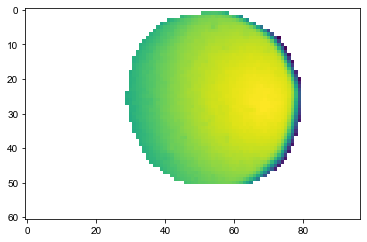

In [137]:
def max_dist(I):
    X = ndi.distance_transform_edt(I)
    x0, y0 = np.unravel_index(X.argmax(), X.shape)
    d0 = np.max(X)
    return x0, y0, d0
    
    
im = images[-1]
im = downscale_local_mean(im, (10, 10))
im_ref = downscale_local_mean(im_read, (10, 10))
plt.figure()
v = 3
plt.imshow(im>v)
plt.figure()
plt.imshow(im_ref>4)

n=20
im2 = np.copy(im)
im2[im2>n] = n

#shift, error, diffphase = skimage.registration.phase_cross_correlation(im_ref, im, upsample_factor=100)

x0, y0, d0 = max_dist(im>v) #1
x1, y1, d1 = max_dist(im_ref>4)

shift = [y1 - y0, x1 - x0]
tform = skimage.transform.AffineTransform(translation = shift)

I_480_t = skimage.transform.warp(I_480, tform)
transfert = im / I_480_t

mask_t = skimage.transform.warp(mask, tform)
plt.figure()
plt.imshow(transfert*mask_t)
plt.figure()
plt.imshow(np.log(transfert*mask_t))
plt.savefig('images/transfert_function_690nm' + extension)

In [138]:
mean_480 = []

for i in range(9):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_480.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)

mean_480 =np.array(mean_480)

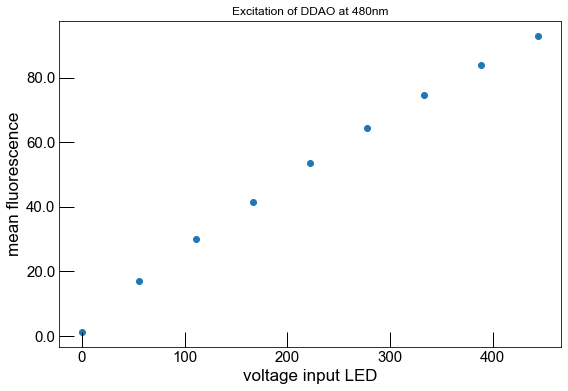

In [139]:
fig = p.set_figure("%d", "%0.1f")
plt.scatter(voltages[:-1], mean_480)
plt.xlabel("voltage input LED")
plt.ylabel("mean fluorescence")
plt.title("Excitation of DDAO at 480nm")

plt.savefig("images/excitation_ddao_480_various_intensities" + extension)

0.0 -75.15287935511357
55.55555555555556 1233.0614407143087
111.11111111111111 2514.3076349886305
166.66666666666669 3759.3999356625186
222.22222222222223 4959.729225048728
277.77777777777777 6107.263035578108
333.33333333333337 7194.545549799603
388.8888888888889 8214.697600380248
444.44444444444446 9161.416670105164


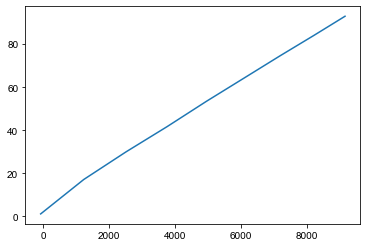

In [151]:
V = VoltageIntensity(folder = glob.glob("*_bode_diagram_DRONPA2_july3*")[0])


def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude, lbd):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    eins=power*1e-3*1e3*lbd/120/S
    
    return eins

blues = []
for i in range(9):
    intensity_blue = V.get_intensity_voltage("blue", 0.5, voltages[i]/100) * dronpa_480 / ( V.get_intensity_voltage("blue", 0.5, 400/100))
    print(voltages[i], intensity_blue)
    blues.append(intensity_blue)
plt.plot(blues, mean_480)
blues = np.array(blues)


# RED

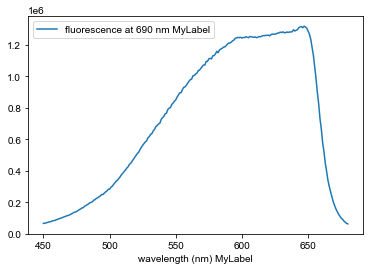

In [152]:
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
spectrum.plot(x = headers[1], y = headers[2])
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])


In [153]:
fluo[wavelength == 480]/fluo[wavelength == lbd]

array([0.12799801])

0.25
intensity predicted 1174.298410469649
intensity MPPC 795.4178384054572


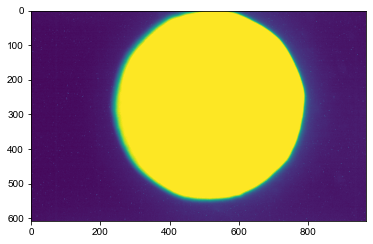

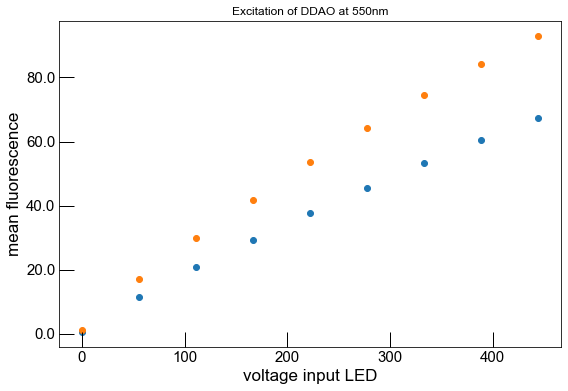

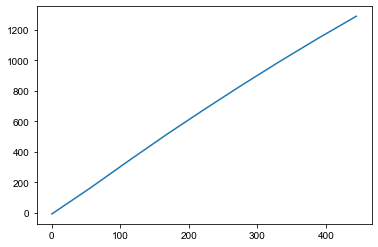

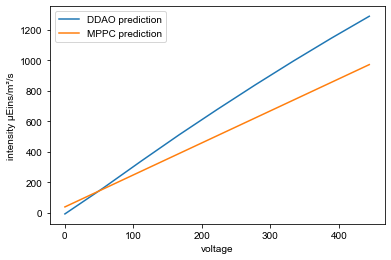

In [162]:
lbd = 550

f = folder_GREEN
dic = dict_green

images = glob.glob(f + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(f + "/voltage.npy")[0]
voltages = np.load(voltages)

im = np.sum(images, axis = 0)
n=150
im[im>n] = n
plt.imshow(im)

mean_640 = []

for i in range(9):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_640.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)
mean_640 = np.array(mean_640)

fig = p.set_figure("%d", "%0.1f")
plt.scatter(voltages[:-1], mean_640)
plt.scatter(voltages[:-1], mean_480)
plt.xlabel("voltage input LED")
plt.ylabel("mean fluorescence")
plt.title("Excitation of DDAO at %dnm"%lbd)

plt.savefig("images/excitation_ddao_%d_various_intensities"%lbd + extension)

S = 0.25#*(d0/d1)**2
print(S)

fluo = np.array(spectrum[headers[2]])
reds = blues * mean_640/mean_480 * fluo[wavelength == 480]/fluo[wavelength == lbd]
plt.figure()
plt.plot(voltages[:-1], reds)

func = get_polyfit_func(voltages[:-1], reds, 2)

print("intensity predicted", func(400))
print("intensity MPPC", amp_to_eins(dic, 400, lbd))

plt.figure()
plt.plot(voltages[:-1], reds, label = "DDAO prediction")
plt.plot(voltages[:-1], 84/76*amp_to_eins(dic, voltages[:-1], lbd), label = "MPPC prediction")
plt.xlabel("voltage")
plt.ylabel("intensity µEins/m²/s")
plt.legend()

In [155]:
amp_to_eins(dic, reds, lbd)

array([   5.18039065,  208.06364032,  437.41351254,  674.7162349 ,
        913.2083458 , 1150.73131197, 1386.18488447, 1615.29128449,
       1837.34499268])

## Heterogeneity auto-test blue

In [34]:
images = glob.glob(folder_BLUE+ "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)

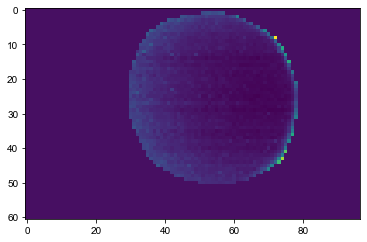

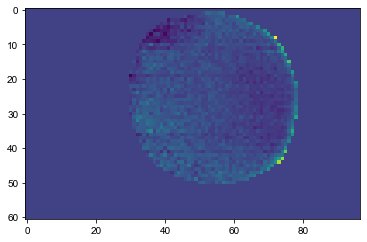

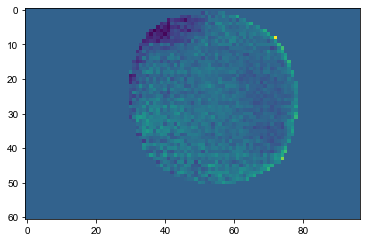

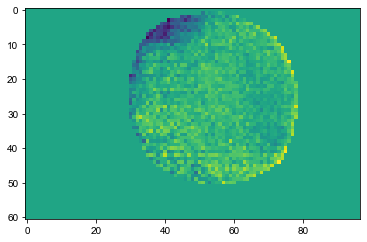

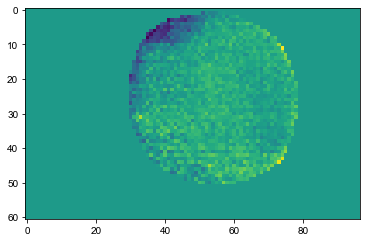

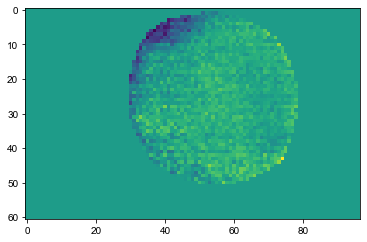

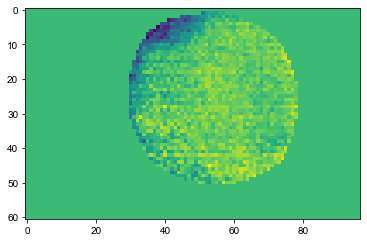

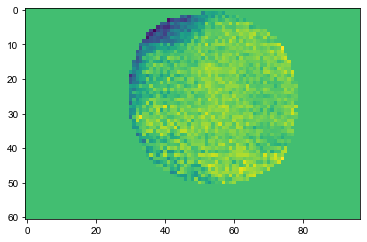

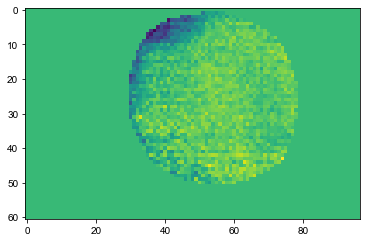

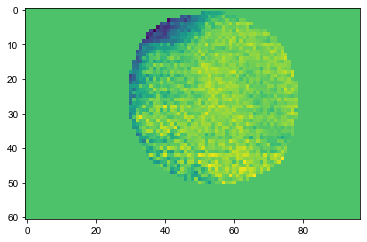

In [35]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    v = im/transfert*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

## Fourier

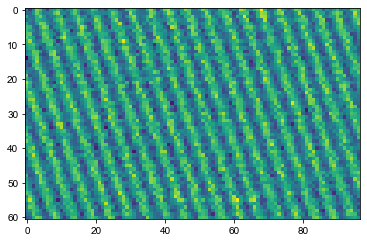

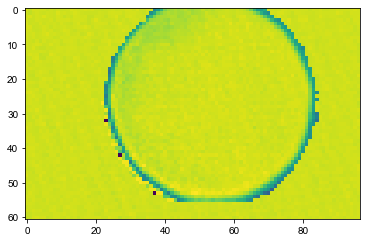

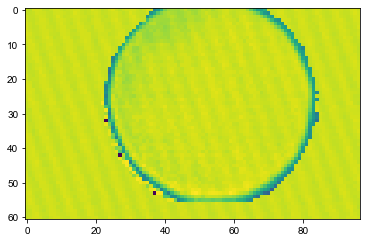

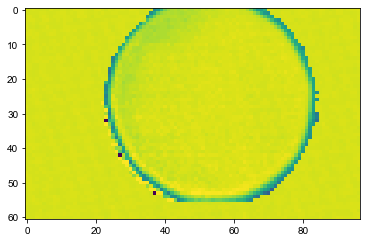

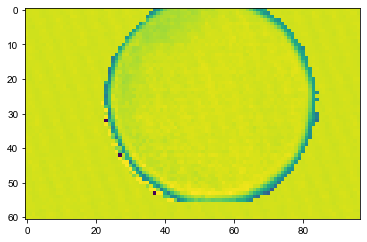

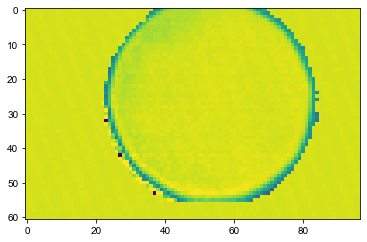

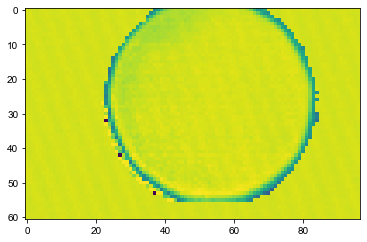

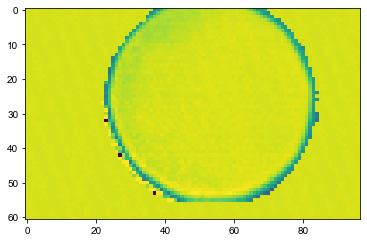

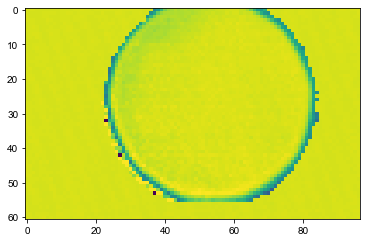

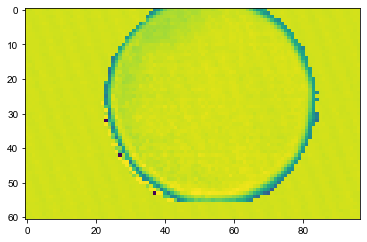

In [36]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    im = prepare_input(im, maskim)
    
    v = make_transfert(im)
    v = v#*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)

## Heterogeneity red

In [37]:
images = glob.glob(folder_RED+ "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_RED + "/voltage.npy")[0]
voltages = np.load(voltages)

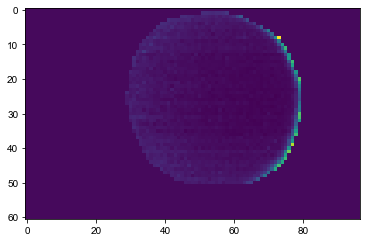

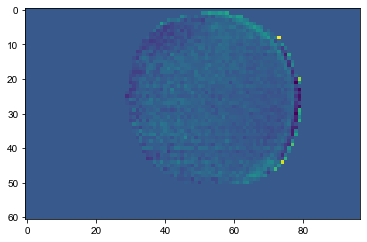

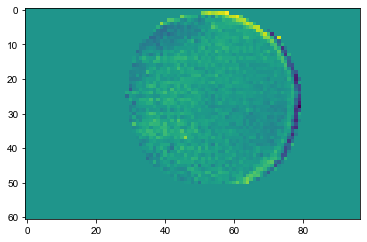

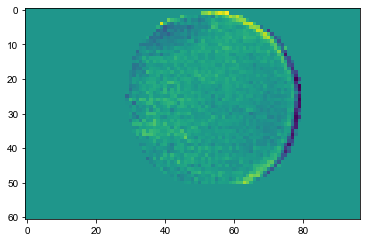

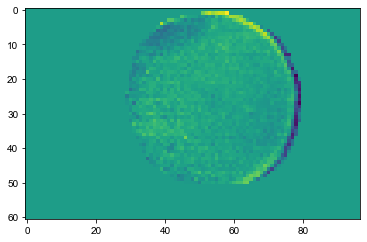

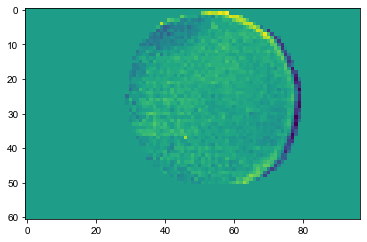

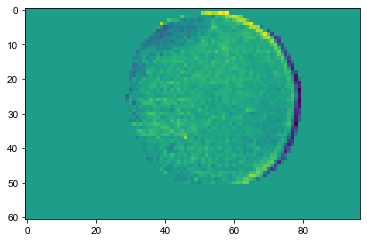

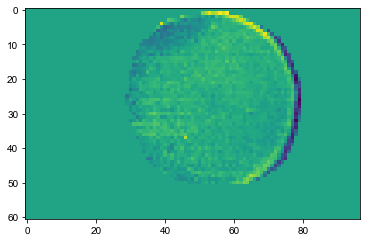

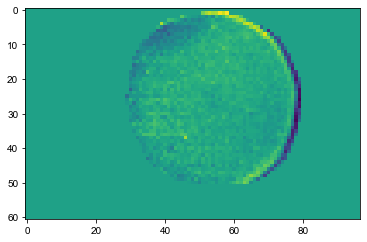

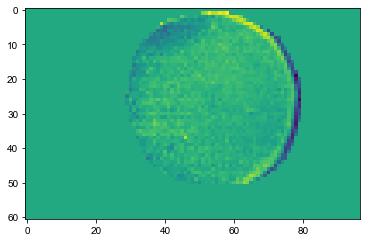

In [163]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    #plt.imshow(im)
    v = im/transfert*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)
    plt.savefig("images/airy_red_LED"+ extension)

In [197]:
I_pred = {}

I_pred[480] = [1309.4976988220938,
1317.3731364297646,
1301.9565441883394,
1309.6075482632023,
1311.8444326788847,
1313.1775606621388,
1317.8293676380117,
1313.4458370737232,
1320.1055592967723,
1312.6160746104179,
1312.515751033852,
1315.5853840970924,
1316.6146549423572,
1310.288781174855,
1321.6017446262456]   
    
    
    
    
I_pred[550] = [1165.1685313687815,
1164.2131618906267,
1171.67204214475,
1174.8803918005888,
1170.7214910329135,
1168.2734147526776,
1171.5753246946765,
1169.2246624015072,
1175.0043195009614,
1171.020912960722,
1173.8696434575045,
1171.0781430443935,
1173.4644409000928,
1173.9982511486949,
1171.833644462479]

I_pred[640] = [1080.7564077031004,
1072.9113943355078,
1078.271978283781,
1077.6316612156404,
1076.3009249639238,
1074.5581395720585,
1074.5870874731067,
1076.9532811022266,
1073.353031346186,
1071.7973324176207,
1071.649249667264,
1072.5094950360008,
1073.9139710673744,
1070.6921596498364]

I_leaf = {}
I_leaf[480] = [1236, 1251, 1110]
I_leaf[550] = [658]
I_leaf[640] = [1250]


I_algae = {}
I_algae[480] = [1247]
I_algae[550] = [788]
I_algae[640] = [485]



In [198]:
wave = np.array([480, 550, 640])
MPPC = np.array([72.9, 50.6, 36.4])
MPPC_int = MPPC*wave/0.25/120
MPPC_int

array([1166.4       ,  927.66666667,  776.53333333])

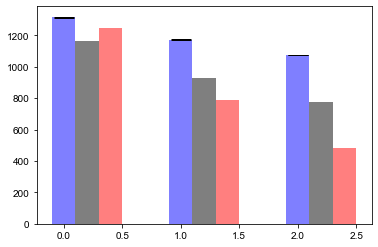

In [200]:
plt.figure()
w = 0.20
for i, k in enumerate(list(I_pred.keys())):
    plt.bar(i,  np.mean(I_pred[k]) , yerr=np.std(I_pred[k]), align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color = "blue")
    plt.bar(i+w,  MPPC_int[i], align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color = "k")
    plt.bar(i+2*w, I_algae[k], align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color = "red")



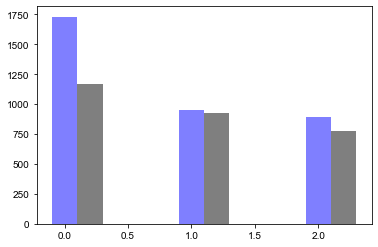

In [201]:
wave = np.array([480, 550, 640])
volt=np.array([60, 400, 400])
MPPC = np.array([72.9, 50.6, 36.4])
MPPC_int = MPPC*wave/0.25/120
DDAO_pred = np.array([1730, 950 , 893 ])
DDAO_int = np.array([5.91, 20 , 29])

plt.figure()
w = 0.20
for i, k in enumerate(list(I_pred.keys())):
    plt.bar(i,  DDAO_pred[i], align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color = "blue")
    plt.bar(i+w,  MPPC_int[i], align='center', alpha=0.5, ecolor='black', capsize=10, width=w, color = "k")
